#### Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.tree_util as jtu

%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# PyTorch device CUDA0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Increase font size to match Beamer template
plt.rcParams["font.size"] = 16
# Make background transparent
plt.rcParams["figure.facecolor"] = "none"
plt.rcParams["font.family"] = "Arial"

## Notation

![](../figures/nn_variants/notation.png)

## Models capturing aleatoric uncertainty

### Dataset containing homoskedastic noise

In [4]:
# Set a fixed random seed for reproducibility
torch.manual_seed(42)

# Define the number of data points
N = 100

# Create a linearly spaced range of values from -1 to 1
x_lin = torch.linspace(-1, 1, N)

# Define a function 'f' to model the data
f = lambda x: 0.5 * x**2 + 0.25 * x**3

# Generate random noise 'eps' with a standard deviation of 0.2
eps = torch.randn(N) * 0.2

# Add noise to the true function to simulate real-world data
y = f(x_lin) + eps

# Move data to the GPU if available (assuming 'device' is defined)
x_lin = x_lin.to(device)
y = y.to(device)

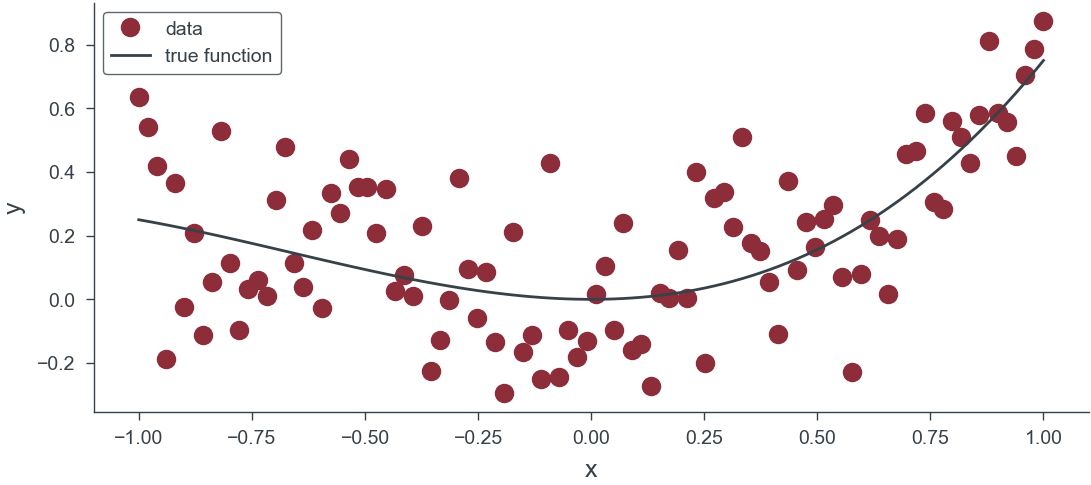

In [5]:
# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(),'o', label="data")
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label="true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


### Case 1.1: Models assuming Homoskedastic noise


#### Case 1.1.1: Homoskedastic noise is fixed beforehand and not learned

![](../figures/nn_variants/homo_fixed_noise.png)

In [6]:
class MeanEstimateNN(torch.nn.Module):
    def __init__(self, n_hidden=4):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        mu_hat = self.fc3(x)
        return mu_hat


In [7]:
def loss_homoskedastic_noise(model, x, y, params):
    """
    Compute the Negative Log Likelihood (NLL) loss for data with Homoskedastic Noise.
    It assumes that the noise standard deviation is provided as a parameter.

    Args:
        model (torch.nn.Module): The neural network model used for mean estimation.
        x (torch.Tensor): Input data tensor.
        y (torch.Tensor): Target data tensor.
        params (dict): A dictionary containing model parameters, including 'log_noise_std'.

    Returns:
        torch.Tensor: The negative log likelihood loss for the given data.

    """
    # Extract the log noise standard deviation from the parameters
    log_noise_std = params["log_noise_std"]

    # Compute the estimated mean using the model
    mu_hat = model(x).squeeze()

    # Ensure the shapes of mu_hat and y are compatible
    assert mu_hat.shape == y.shape

    # Compute the noise standard deviation based on the log value
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)

    # Create a Normal distribution with mean mu_hat and standard deviation noise_std
    dist = torch.distributions.Normal(mu_hat, noise_std)

    # Calculate the negative log likelihood loss and take the mean
    return -dist.log_prob(y).mean()

In [8]:
homoskedastic_model_fixed_noise = MeanEstimateNN().to(device)
homoskedastic_model_fixed_noise

MeanEstimateNN(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [9]:
fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)
params = {
    "nn_params": homoskedastic_model_fixed_noise.state_dict(),
    "log_noise_std": fixed_log_noise_std,
}
loss_homoskedastic_noise(homoskedastic_model_fixed_noise, x_lin[:, None], y, params)

tensor(0.6247, grad_fn=<NegBackward0>)

In [10]:
def plot_results(y_hat, epistemic_std=None, aleatoric_std=None, model_name=""):
    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color="C0", label="Data")
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color="C1", label="True function")
    plt.plot(x_lin.cpu(), y_hat.cpu(), color="C2", label=model_name)
    if epistemic_std is not None:
        plt.fill_between(
            x_lin.cpu(),
            (y_hat - 2 * epistemic_std).cpu(),
            (y_hat + 2 * epistemic_std).cpu(),
            alpha=0.3,
            color="C3",
            label="Epistemic uncertainty",
        )
    if aleatoric_std is not None:
        plt.fill_between(
            x_lin.cpu(),
            (y_hat - 2 * aleatoric_std).cpu(),
            (y_hat + 2 * aleatoric_std).cpu(),
            alpha=0.3,
            color="C2",
            label="Aleatoric uncertainty",
        )

    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed


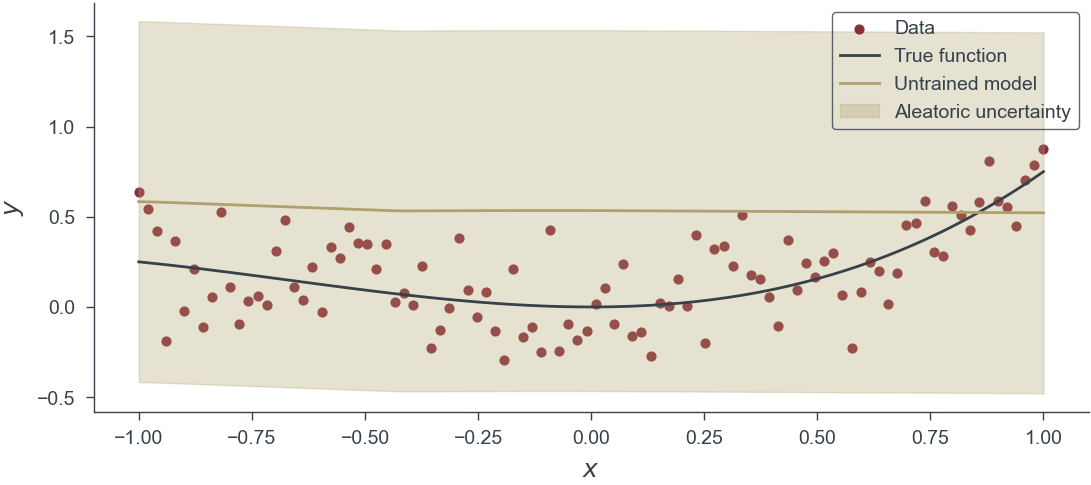

In [11]:
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()

plot_results(
    y_hat, aleatoric_std=torch.exp(fixed_log_noise_std), model_name="Untrained model"
)


In [12]:
def train_fn(model, loss_func, params, x, y, n_epochs=1000, lr=0.01):
    parameter_leaves = jtu.tree_leaves(params)
    optimizer = torch.optim.Adam(parameter_leaves, lr=lr)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_func(model, x, y, params)
        loss.backward()
        optimizer.step()
        # Print every 10 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: loss {loss.item():.3f}")
    return loss.item()


In [13]:
homoskedastic_model_fixed_noise = MeanEstimateNN().to(device)
params = {
    "nn_params": list(homoskedastic_model_fixed_noise.parameters()),
    "log_noise_std": fixed_log_noise_std,
}

In [14]:
train_fn(
    homoskedastic_model_fixed_noise,
    loss_homoskedastic_noise,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.001,
)

Epoch 0: loss 0.399
Epoch 50: loss 0.374
Epoch 100: loss 0.368
Epoch 150: loss 0.367
Epoch 200: loss 0.366
Epoch 250: loss 0.364
Epoch 300: loss 0.362
Epoch 350: loss 0.357
Epoch 400: loss 0.349
Epoch 450: loss 0.339
Epoch 500: loss 0.329
Epoch 550: loss 0.322
Epoch 600: loss 0.317
Epoch 650: loss 0.314
Epoch 700: loss 0.313
Epoch 750: loss 0.312
Epoch 800: loss 0.312
Epoch 850: loss 0.312
Epoch 900: loss 0.311
Epoch 950: loss 0.311


0.3111453354358673

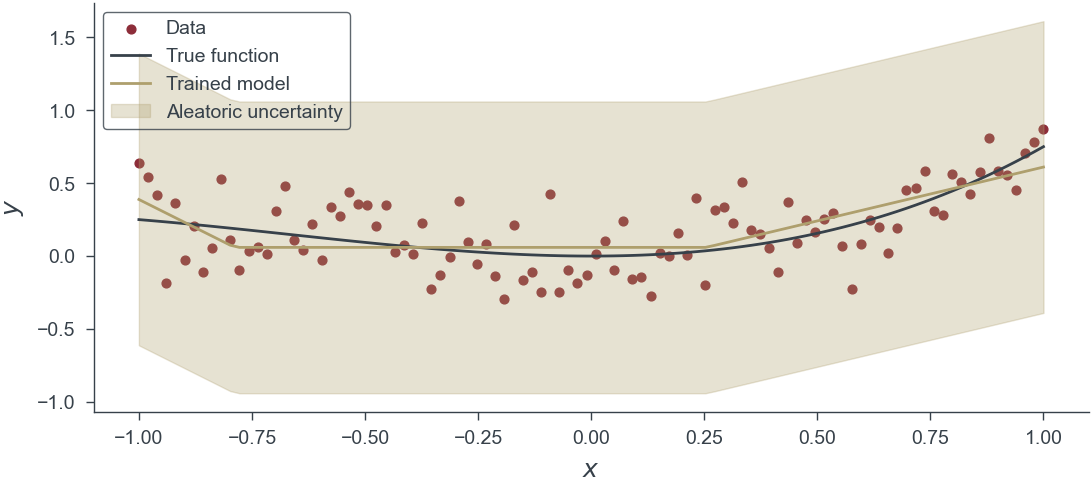

In [15]:
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(fixed_log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Trained model")


#### Case 1.1.2: Homoskedastic noise is learnt from the data

![](../figures/nn_variants/homo_trainable_noise.png)

The model is the same as in case 1.1.1, but the noise is learned from the data.

In [16]:
homoskedastic_model_learnable_noise = MeanEstimateNN().to(device)
# We keep the noise_std as a parameter, instead of a fixed value
# Earlier code was: fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)
log_noise_std = torch.nn.Parameter(torch.tensor(0.0).to(device))

homoskedastic_model_learnable_noise

MeanEstimateNN(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

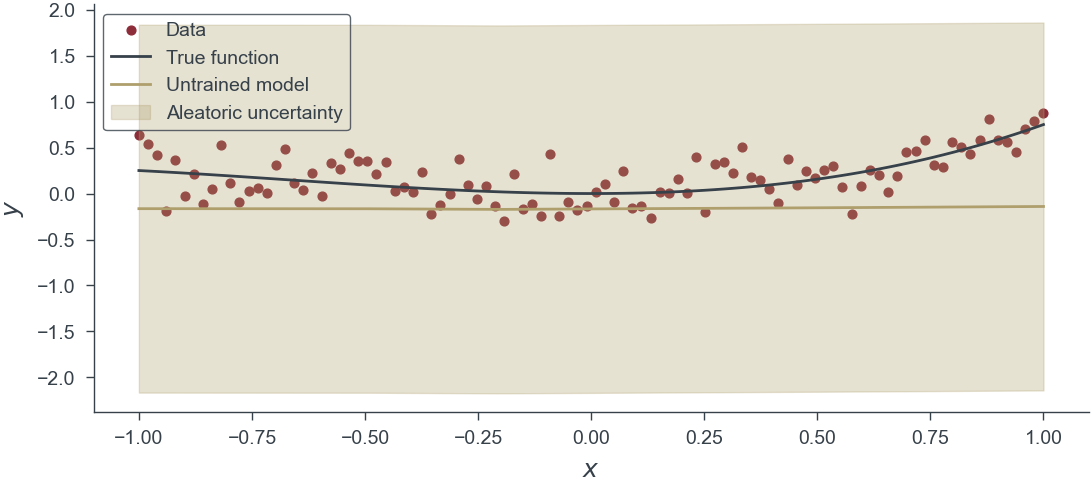

In [17]:
# Plot the untrained model
with torch.no_grad():
    y_hat = homoskedastic_model_learnable_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Untrained model")

In [18]:
# Train the model
homoskedastic_model_learnable_noise = MeanEstimateNN().to(device)
params = {
    "nn_params": list(homoskedastic_model_learnable_noise.parameters()),
    "log_noise_std": log_noise_std,
}

In [19]:
jtu.tree_leaves(params) 

[Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor([[ 0.9673],
         [ 0.1447],
         [-0.2590],
         [ 0.4137]], requires_grad=True),
 Parameter containing:
 tensor([-0.3809, -0.6473,  0.7299, -0.4547], requires_grad=True),
 Parameter containing:
 tensor([[-0.1002, -0.4974,  0.3346,  0.3788],
         [ 0.1822, -0.3486, -0.4935, -0.4061],
         [ 0.3729,  0.2401,  0.4208,  0.2619],
         [ 0.1265, -0.0049, -0.3803, -0.4284]], requires_grad=True),
 Parameter containing:
 tensor([-0.4677,  0.2047, -0.2455, -0.1006], requires_grad=True),
 Parameter containing:
 tensor([[-0.2878, -0.0911, -0.3519, -0.3267]], requires_grad=True),
 Parameter containing:
 tensor([0.1659], requires_grad=True)]

In [20]:
[log_noise_std] + list(homoskedastic_model_learnable_noise.parameters()) 

[Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor([[ 0.9673],
         [ 0.1447],
         [-0.2590],
         [ 0.4137]], requires_grad=True),
 Parameter containing:
 tensor([-0.3809, -0.6473,  0.7299, -0.4547], requires_grad=True),
 Parameter containing:
 tensor([[-0.1002, -0.4974,  0.3346,  0.3788],
         [ 0.1822, -0.3486, -0.4935, -0.4061],
         [ 0.3729,  0.2401,  0.4208,  0.2619],
         [ 0.1265, -0.0049, -0.3803, -0.4284]], requires_grad=True),
 Parameter containing:
 tensor([-0.4677,  0.2047, -0.2455, -0.1006], requires_grad=True),
 Parameter containing:
 tensor([[-0.2878, -0.0911, -0.3519, -0.3267]], requires_grad=True),
 Parameter containing:
 tensor([0.1659], requires_grad=True)]

In [21]:
jtu.tree_leaves(params) == [log_noise_std] + list(homoskedastic_model_learnable_noise.parameters()) 

True

In [22]:

train_fn(
    homoskedastic_model_learnable_noise,
    loss_homoskedastic_noise,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.01,
)

Epoch 0: loss 0.958
Epoch 50: loss 0.522
Epoch 100: loss 0.218
Epoch 150: loss 0.109
Epoch 200: loss 0.100
Epoch 250: loss 0.100
Epoch 300: loss 0.100
Epoch 350: loss 0.100
Epoch 400: loss 0.100
Epoch 450: loss 0.100
Epoch 500: loss 0.100
Epoch 550: loss 0.100
Epoch 600: loss 0.100
Epoch 650: loss 0.100
Epoch 700: loss 0.100
Epoch 750: loss 0.100
Epoch 800: loss 0.100
Epoch 850: loss 0.100
Epoch 900: loss 0.100
Epoch 950: loss 0.100


0.09978220611810684

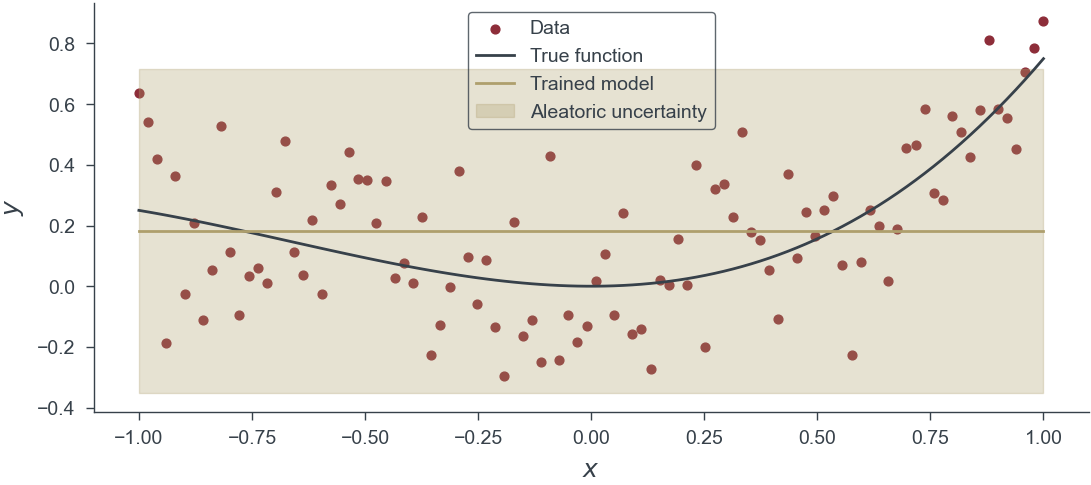

In [23]:
# Plot the trained model
with torch.no_grad():
    y_hat = homoskedastic_model_learnable_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Trained model")

### Case 1.2: Models assuming heteroskedastic noise

![](../figures/nn_variants/hetero_trainable_noise.png)

In [24]:
class HeteroskedasticNN(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 2)  # we learn both mu and log_noise_std

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        z = self.fc3(x)
        mu_hat = z[:, 0]
        log_noise_std = z[:, 1]
        return mu_hat, log_noise_std

In [25]:
heteroskedastic_model = HeteroskedasticNN().to(device)
heteroskedastic_model

HeteroskedasticNN(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

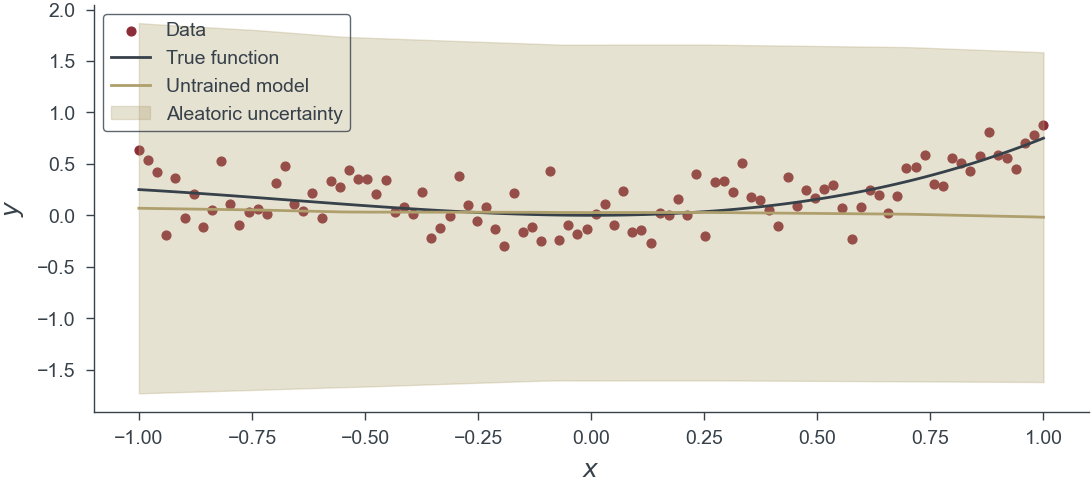

In [26]:
# Plot the untrained model
with torch.no_grad():
    y_hat, log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Untrained model")

In [27]:
def loss_heteroskedastic(model, x, y, params):
    mu_hat, log_noise_std = model(x)
    noise_std = torch.exp(log_noise_std)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()


params = list(heteroskedastic_model.parameters())
train_fn(
    heteroskedastic_model,
    loss_heteroskedastic,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.01,
)

Epoch 0: loss 0.809
Epoch 50: loss -0.077
Epoch 100: loss -0.203
Epoch 150: loss -0.204
Epoch 200: loss -0.204
Epoch 250: loss -0.204
Epoch 300: loss -0.204
Epoch 350: loss -0.204
Epoch 400: loss -0.204
Epoch 450: loss -0.205
Epoch 500: loss -0.205
Epoch 550: loss -0.205
Epoch 600: loss -0.205
Epoch 650: loss -0.205
Epoch 700: loss -0.205
Epoch 750: loss -0.205
Epoch 800: loss -0.205
Epoch 850: loss -0.205
Epoch 900: loss -0.205
Epoch 950: loss -0.206


-0.20577675104141235

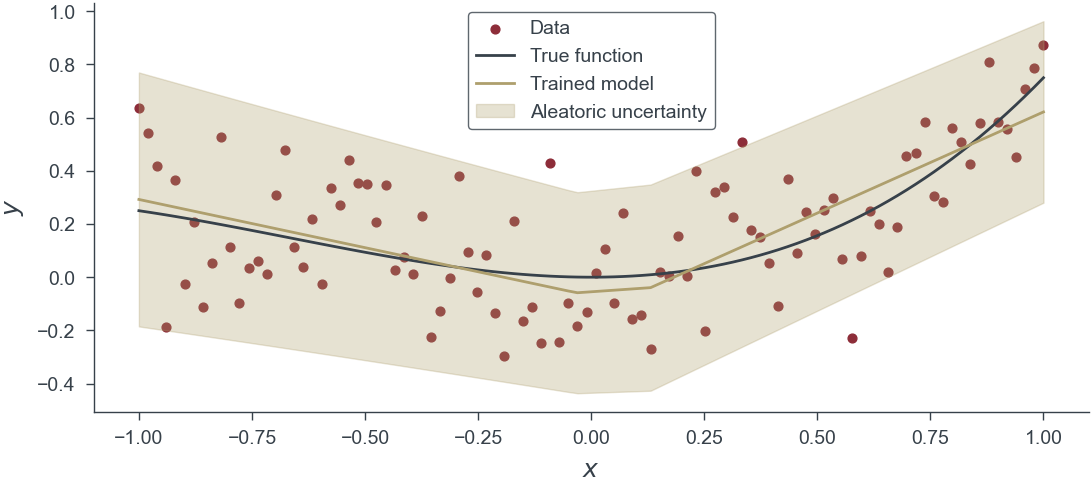

In [28]:
# Plot the trained model
with torch.no_grad():
    y_hat, log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Trained model")

### Data with heteroskedastic noise

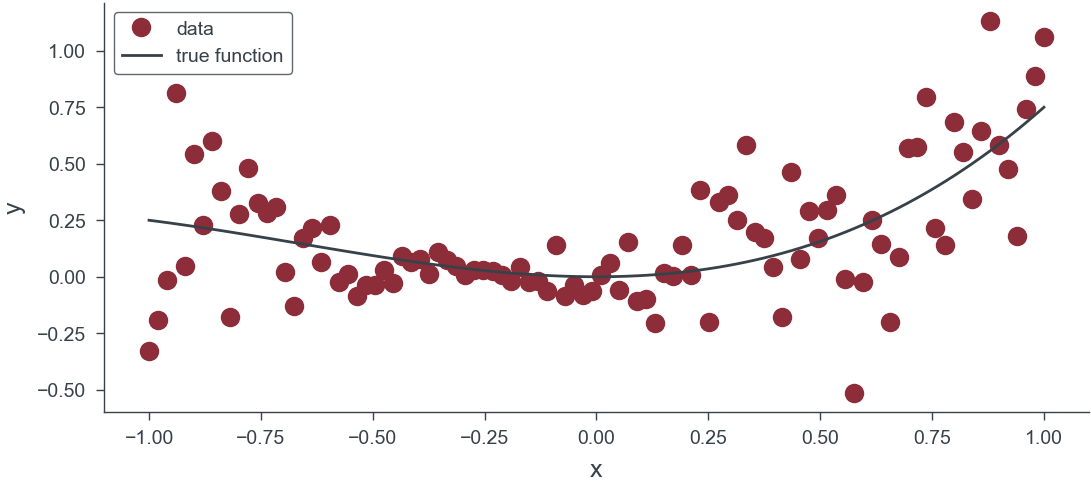

In [29]:
torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * (0.1 + 0.4 * x_lin)

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)

# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), "o", label="data")
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label="true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

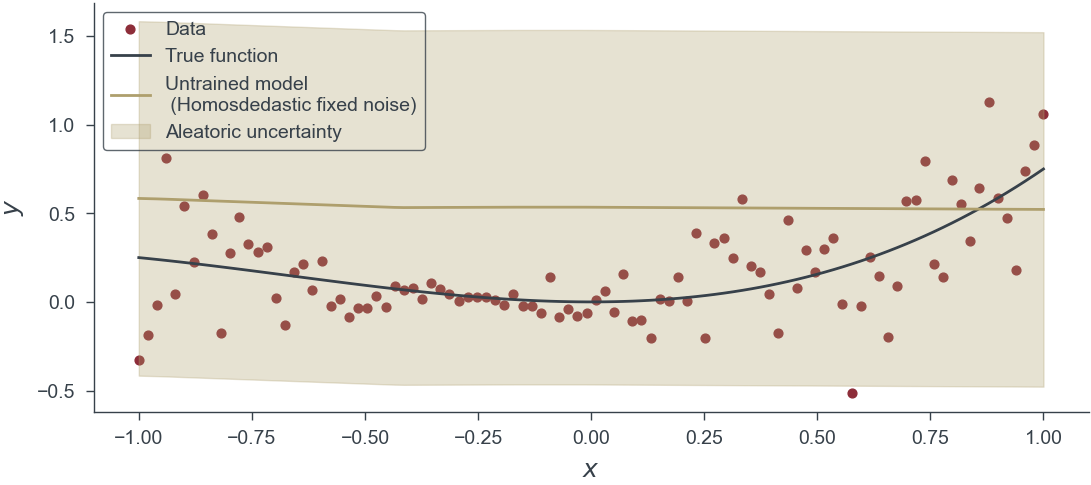

In [30]:
homoskedastic_model_fixed_noise = MeanEstimateNN().to(device)
fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)

# Plot the untrained model
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(fixed_log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Untrained model\n (Homosdedastic fixed noise)")

Epoch 0: loss 0.668
Epoch 50: loss 0.543
Epoch 100: loss 0.466
Epoch 150: loss 0.423
Epoch 200: loss 0.401
Epoch 250: loss 0.393
Epoch 300: loss 0.389
Epoch 350: loss 0.385
Epoch 400: loss 0.382
Epoch 450: loss 0.379
Epoch 500: loss 0.376
Epoch 550: loss 0.372
Epoch 600: loss 0.369
Epoch 650: loss 0.366
Epoch 700: loss 0.362
Epoch 750: loss 0.358
Epoch 800: loss 0.354
Epoch 850: loss 0.350
Epoch 900: loss 0.347
Epoch 950: loss 0.344


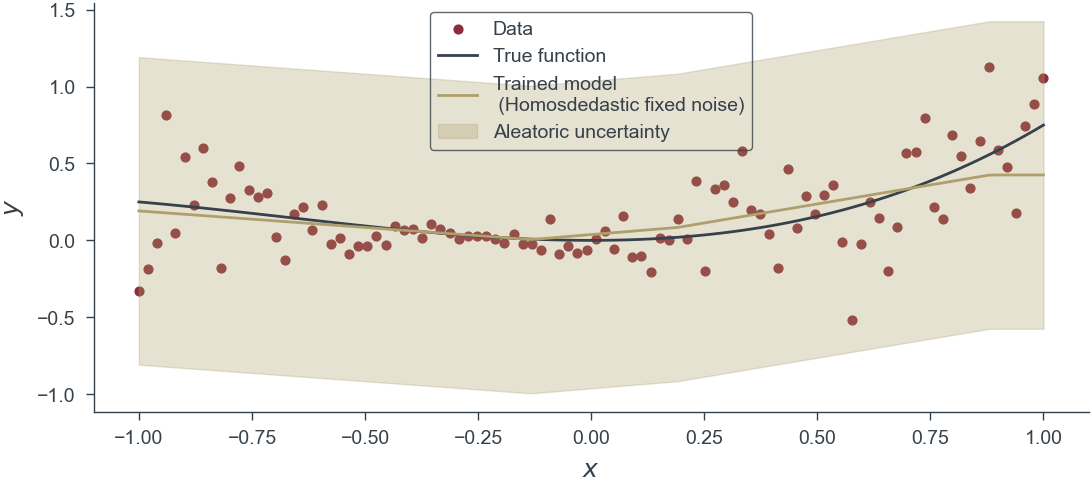

In [31]:
params = {
    "nn_params": list(homoskedastic_model_fixed_noise.parameters()),
    "log_noise_std": fixed_log_noise_std,
}
train_fn(
    homoskedastic_model_fixed_noise,
    loss_homoskedastic_noise,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.001,
)

# Plot the trained model
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(fixed_log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Trained model\n (Homosdedastic fixed noise)")


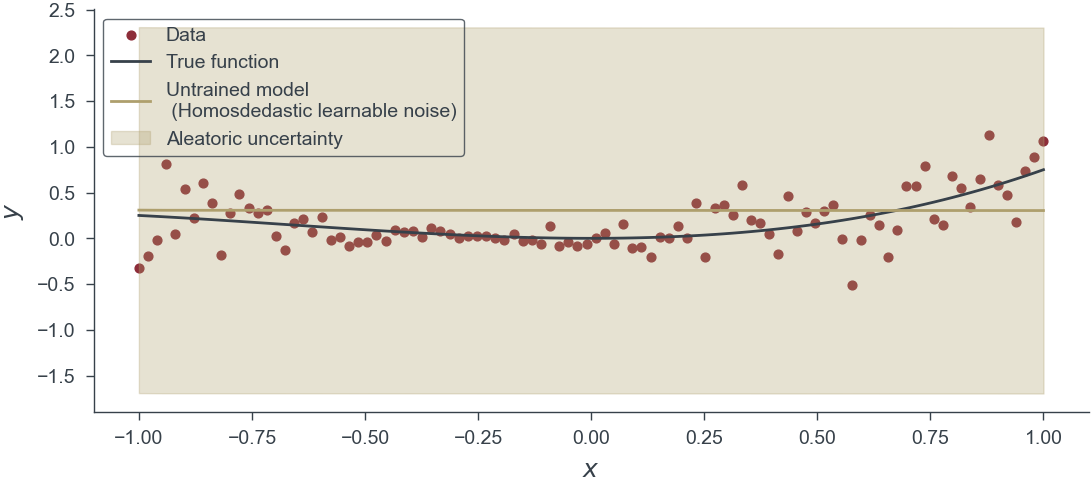

In [32]:
# Now, fit the homoskedastic model with learned noise

homoskedastic_model_learnable_noise = MeanEstimateNN().to(device)
log_noise_std = torch.nn.Parameter(torch.tensor(0.0).to(device))

# Plot the untrained model
with torch.no_grad():
    y_hat = homoskedastic_model_learnable_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Untrained model\n (Homosdedastic learnable noise)")

Epoch 0: loss 0.971
Epoch 50: loss 0.523
Epoch 100: loss 0.143
Epoch 150: loss -0.036
Epoch 200: loss -0.063
Epoch 250: loss -0.063
Epoch 300: loss -0.063
Epoch 350: loss -0.063
Epoch 400: loss -0.063
Epoch 450: loss -0.063
Epoch 500: loss -0.063
Epoch 550: loss -0.063
Epoch 600: loss -0.063
Epoch 650: loss -0.063
Epoch 700: loss -0.063
Epoch 750: loss -0.063
Epoch 800: loss -0.063
Epoch 850: loss -0.063
Epoch 900: loss -0.063
Epoch 950: loss -0.063


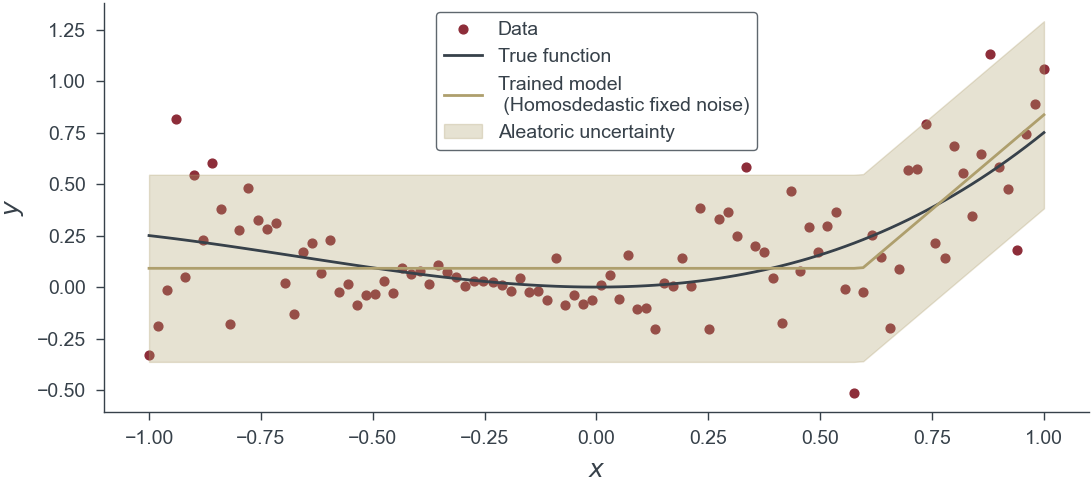

In [33]:
# Train the model
params = {
    "nn_params": list(homoskedastic_model_learnable_noise.parameters()),
    "log_noise_std": log_noise_std,
}

train_fn(
    homoskedastic_model_learnable_noise,
    loss_homoskedastic_noise,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.01,
)

# Plot the trained model
with torch.no_grad():
    y_hat = homoskedastic_model_learnable_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Trained model\n (Homosdedastic fixed noise)")

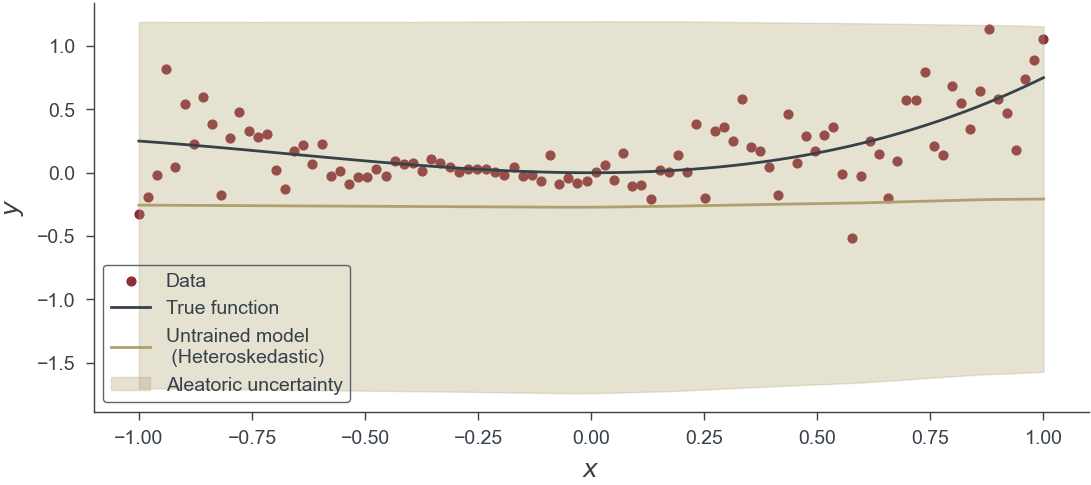

In [34]:
# Now, fit the heteroskedastic model

heteroskedastic_model = HeteroskedasticNN().to(device)

# Plot the untrained model
with torch.no_grad():
    y_hat, log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Untrained model\n (Heteroskedastic)")

In [35]:
# Train the model
params = list(heteroskedastic_model.parameters())

train_fn(
    heteroskedastic_model,
    loss_heteroskedastic,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.01,
)

Epoch 0: loss 0.849
Epoch 50: loss 0.023
Epoch 100: loss -0.083
Epoch 150: loss -0.334
Epoch 200: loss -0.446
Epoch 250: loss -0.476
Epoch 300: loss -0.488
Epoch 350: loss -0.508
Epoch 400: loss -0.536
Epoch 450: loss -0.548
Epoch 500: loss -0.557
Epoch 550: loss -0.560
Epoch 600: loss -0.569
Epoch 650: loss -0.571
Epoch 700: loss -0.573
Epoch 750: loss -0.577
Epoch 800: loss -0.585
Epoch 850: loss -0.591
Epoch 900: loss -0.597
Epoch 950: loss -0.602


-0.6052244305610657

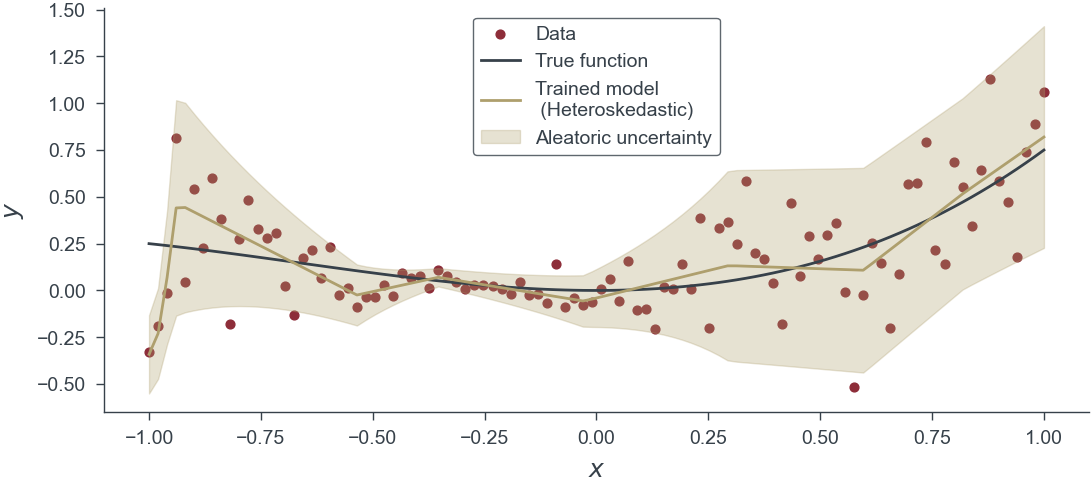

In [36]:
# Plot the trained model
with torch.no_grad():
    y_hat, log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Trained model\n (Heteroskedastic)")

### Epistemic Uncertainty: Bayesian NN with Laplace approximation

#### MAP estimation

In [37]:
def negative_log_prior(model):
    log_prior = 0.0

    for param in model.parameters():
        log_prior += torch.distributions.Normal(0, 1).log_prob(param).sum()
    return -log_prior


def negative_log_likelihood(model, x, y, log_noise_std):
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).sum()


def negative_log_joint(model, x, y, log_noise_std):
    return negative_log_likelihood(model, x, y, log_noise_std) + negative_log_prior(
        model
    )


In [38]:
def custom_loss_fn(model, x, y, params):
    log_noise_std = params["log_noise_std"]
    return negative_log_joint(model, x, y, log_noise_std)


torch.manual_seed(3)
laplace_model = MeanEstimateNN().to(device)
fixed_log_noise_std = torch.log(torch.tensor(0.2)).to(device)
params = {
    "log_noise_std": fixed_log_noise_std,
    "nn_params": list(laplace_model.parameters()),
}

train_fn(
    laplace_model,
    custom_loss_fn,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.01,
)


Epoch 0: loss 432.107
Epoch 50: loss 60.465
Epoch 100: loss 40.892
Epoch 150: loss 31.322
Epoch 200: loss 30.996
Epoch 250: loss 30.904
Epoch 300: loss 30.834
Epoch 350: loss 30.768
Epoch 400: loss 30.635
Epoch 450: loss 30.508
Epoch 500: loss 30.415
Epoch 550: loss 30.366
Epoch 600: loss 30.319
Epoch 650: loss 30.280
Epoch 700: loss 30.243
Epoch 750: loss 30.211
Epoch 800: loss 30.181
Epoch 850: loss 30.155
Epoch 900: loss 30.130
Epoch 950: loss 30.104


30.08391761779785

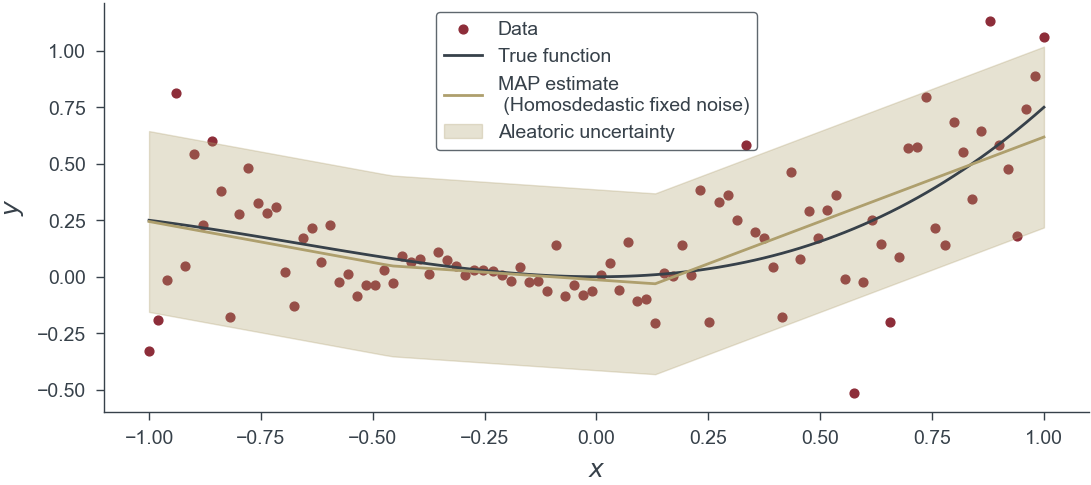

In [39]:
with torch.no_grad():
    y_hat = laplace_model(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(fixed_log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="MAP estimate\n (Homosdedastic fixed noise)")

![](../diagrams/la.png)

#### What weighs to consider?

![](../diagrams/la-redux.png)

#### Goal: Compute the Hessian of the negative log joint wrt the last layer weights

#### Challenge: The negative log joint is a function of all the weights, not just the last layer weights

#### Aside on functools.partial

>The functools module is for higher-order functions: functions that act on or return other functions. In general, any callable object can be treated as a function for the purposes of this module.



In [40]:
print(int("1001", base=2), int("1001", base=4), int("1001"))

from functools import partial

base_two = partial(int, base=2)
base_two.__doc__ = "Convert base 2 string to an int."

print(base_two)
print(base_two.__doc__)
print(help(base_two))
print(base_two("1001"))

9 65 1001
functools.partial(<class 'int'>, base=2)
Convert base 2 string to an int.
Help on partial in module functools:

functools.partial(<class 'int'>, base=2)
    Convert base 2 string to an int.

None
9


#### A primer on functional calls to PyTorch

In [88]:
tiny_model = torch.nn.Linear(3, 1)
input = torch.randn(2, 3)
target = torch.randn(2, 1)
tiny_model

Linear(in_features=3, out_features=1, bias=True)

In [66]:
output = tiny_model(input)
output

tensor([[-1.1665],
        [ 0.7573]], grad_fn=<AddmmBackward0>)

In [67]:
loss_fn = torch.nn.MSELoss()
loss = loss_fn(output, target)
loss.backward()

grad_dict = {"weight": tiny_model.weight.grad, "bias": tiny_model.bias.grad}
grad_dict

{'weight': tensor([[-2.2744,  1.0267, -0.2821]]), 'bias': tensor([-1.5884])}

In [81]:
params = dict(tiny_model.named_parameters())
output = torch.func.functional_call(tiny_model, params, input)
output

tensor([[-1.1665],
        [ 0.7573]], grad_fn=<AddmmBackward0>)

In [89]:
def custom_loss_fn(params):
    output = torch.func.functional_call(tiny_model, params, input)
    return loss_fn(output, target)


torch.func.grad(custom_loss_fn, argnums=0)(params)


{'weight': tensor([[-0.6996, -0.6168, -0.1514]], grad_fn=<TBackward0>),
 'bias': tensor([-1.0177], grad_fn=<ViewBackward0>)}

It is also possible to get the gradients/hessian with respect to only a few weights.

In [92]:
def custom_loss_fn(partial_params, params):
    params.update(partial_params)
    output = torch.func.functional_call(tiny_model, params, input)
    return loss_fn(output, target)

partial_params = {"bias": params["bias"]}

torch.func.grad(custom_loss_fn, argnums=0)(partial_params, params)


{'bias': tensor([-1.0177], grad_fn=<ViewBackward0>)}

In [72]:
partial_params

{'fc3.weight': Parameter containing:
 tensor([[-5.1108e-05,  1.0194e+00, -4.7203e-02,  5.4861e-01]],
        requires_grad=True)}

In [73]:
params

{'weight': Parameter containing:
 tensor([[-0.5766,  0.4935, -0.4603]], requires_grad=True),
 'bias': Parameter containing:
 tensor([0.3889], requires_grad=True)}

### Last layer Laplace approximation

In [47]:
def functional_negative_log_prior(partial_params):
    partial_parameter_leaves = jtu.tree_leaves(partial_params)

    log_prior = 0.0
    for param in partial_parameter_leaves:
        log_prior += torch.distributions.Normal(0, 1).log_prob(param).sum()
    return -log_prior


def functional_negative_log_likelihood(
    partial_params, params, model, x, y, log_noise_std
):
    params.update(partial_params)

    mu_hat = torch.func.functional_call(model, params, x).squeeze()
    assert mu_hat.shape == y.shape, f"{mu_hat.shape} != {y.shape}"

    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).sum()


def functional_negative_log_joint(partial_params, params, model, x, y, log_noise_std):
    return functional_negative_log_likelihood(
        partial_params, params, model, x, y, log_noise_std
    ) + functional_negative_log_prior(partial_params)


In [93]:
params = dict(laplace_model.named_parameters())
params.keys()

dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [94]:
partial_params = {"fc3.weight": params["fc3.weight"]}
partial_params

{'fc3.weight': Parameter containing:
 tensor([[-5.1108e-05,  1.0194e+00, -4.7203e-02,  5.4861e-01]],
        requires_grad=True)}

In [95]:
jtu.tree_leaves(partial_params)

[Parameter containing:
 tensor([[-5.1108e-05,  1.0194e+00, -4.7203e-02,  5.4861e-01]],
        requires_grad=True)]

In [51]:
print("Full negative log prior", negative_log_prior(laplace_model))
print(
    "Partial negative log prior",
    functional_negative_log_prior(partial_params),
)

Full negative log prior tensor(32.7651, grad_fn=<NegBackward0>)
Partial negative log prior tensor(4.3470, grad_fn=<NegBackward0>)


In [96]:
print(
    "Full negative log likelihood",
    negative_log_likelihood(laplace_model, x_lin[:, None], y, fixed_log_noise_std),
)
print(
    "Partial negative log likelihood",
    functional_negative_log_likelihood(
        partial_params, params, laplace_model, x_lin[:, None], y, fixed_log_noise_std
    ),
)


Full negative log likelihood tensor(-2.6817, grad_fn=<NegBackward0>)
Partial negative log likelihood tensor(-2.6817, grad_fn=<NegBackward0>)


In [97]:
print(
    "Full negative log joint",
    negative_log_joint(laplace_model, x_lin[:, None], y, fixed_log_noise_std),
)
print(
    "Partial negative log joint",
    functional_negative_log_joint(
        partial_params, params, laplace_model, x_lin[:, None], y, fixed_log_noise_std
    ),
)


Full negative log joint tensor(30.0834, grad_fn=<AddBackward0>)
Partial negative log joint tensor(1.6653, grad_fn=<AddBackward0>)


In [98]:
map_params = dict(laplace_model.named_parameters())
last_layer_params = {"fc3.weight": map_params["fc3.weight"]}

partial_func = partial(
    functional_negative_log_joint,
    params=map_params,
    model=laplace_model,
    x=x_lin[:, None],
    y=y,
    log_noise_std=fixed_log_noise_std,
)

H = torch.func.hessian(partial_func)(last_layer_params)["fc3.weight"]["fc3.weight"]
print(H.shape)

H = H[0, :, 0, :]
print(H.shape)


torch.Size([1, 4, 1, 4])
torch.Size([4, 4])


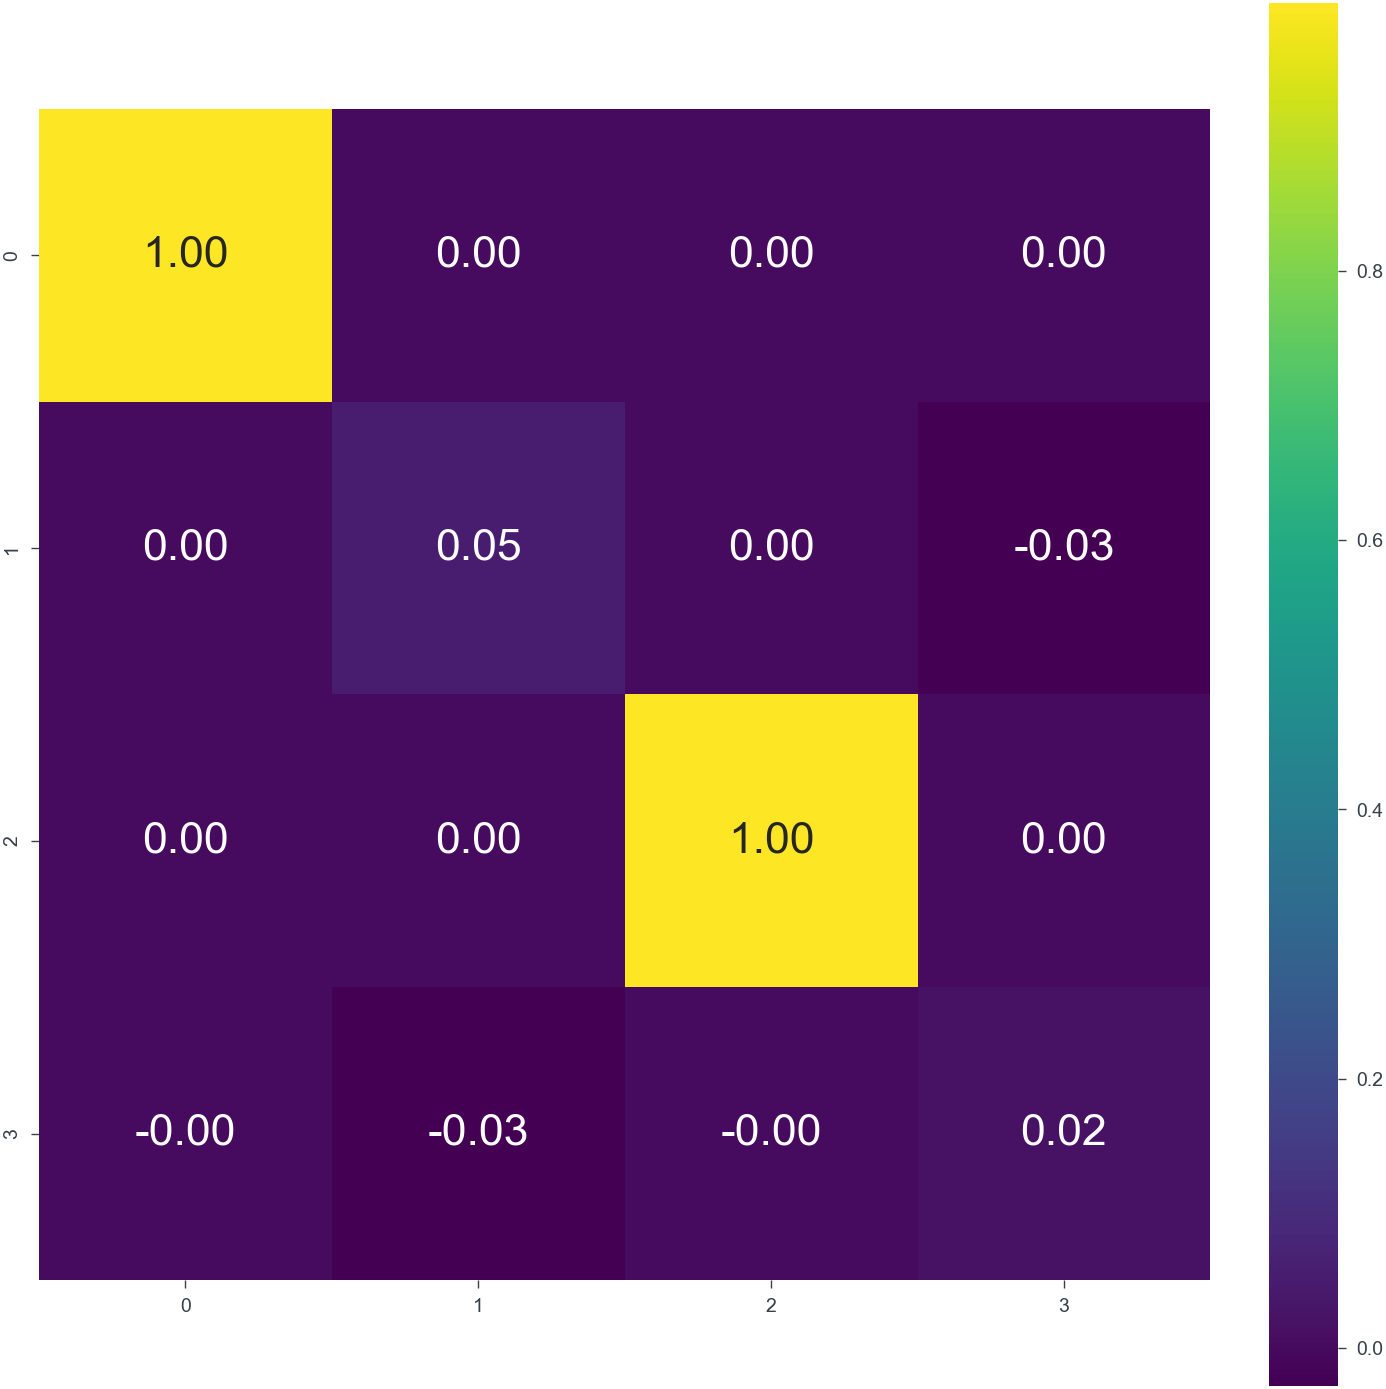

In [99]:
import seaborn as sns

with torch.no_grad():
    cov = torch.inverse(H + 1e-3 * torch.eye(H.shape[0]).to(device))

plt.figure(figsize=(7, 7))
sns.heatmap(cov.cpu().numpy(), annot=True, fmt=".2f", cmap="viridis")
plt.gca().set_aspect("equal", "box")

In [56]:
last_layer_params["fc3.weight"].ravel().shape

torch.Size([4])

In [64]:
cov

tensor([[ 0.9990,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0522,  0.0000, -0.0282],
        [ 0.0000,  0.0000,  0.9990,  0.0000],
        [-0.0000, -0.0282, -0.0000,  0.0184]])

In [57]:
laplace_posterior = torch.distributions.MultivariateNormal(
    last_layer_params["fc3.weight"].ravel(), cov
)
last_layer_weights_samples = laplace_posterior.sample((501,))[..., None]
last_layer_weights_samples.shape

torch.Size([501, 4, 1])

In [58]:
def forward_pass(last_layer_weight, params):
    params.update({"fc3.weight": last_layer_weight.reshape(1, -1)})
    return torch.func.functional_call(laplace_model, params, x_lin[:, None]).squeeze()


forward_pass(last_layer_weights_samples[0], params).shape


torch.Size([100])

In [59]:
mc_outputs = torch.vmap(lambda x: forward_pass(x, params))(last_layer_weights_samples)
print(mc_outputs.shape)


torch.Size([501, 100])


In [60]:
mean_mc_outputs = mc_outputs.mean(0)
std_mc_outputs = mc_outputs.std(0)
mean_mc_outputs.shape, std_mc_outputs.shape


(torch.Size([100]), torch.Size([100]))

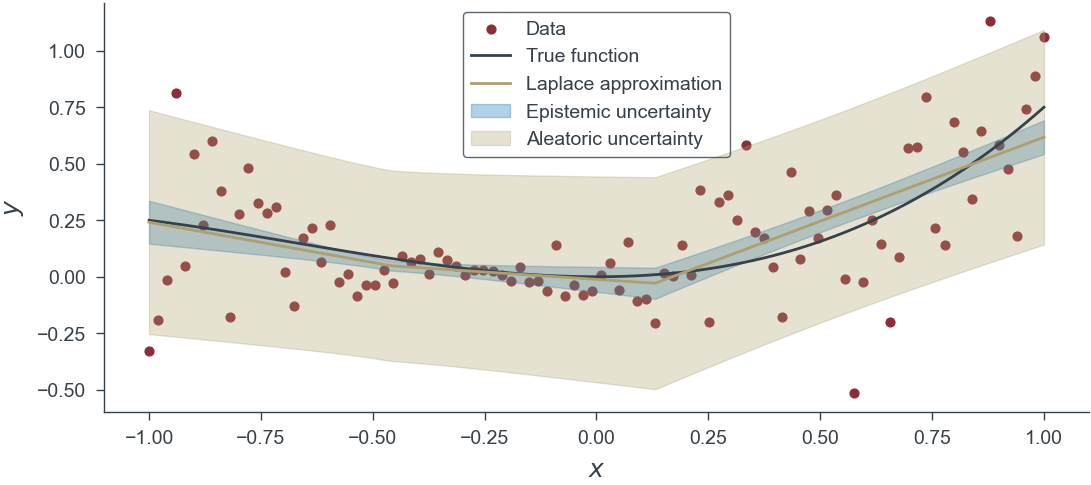

In [61]:
with torch.no_grad():
    epistemic_std = std_mc_outputs
    aleatoric_std = torch.exp(fixed_log_noise_std) + epistemic_std

    plot_results(
        mean_mc_outputs,
        epistemic_std=epistemic_std,
        aleatoric_std=aleatoric_std,
        model_name="Laplace approximation",
    )


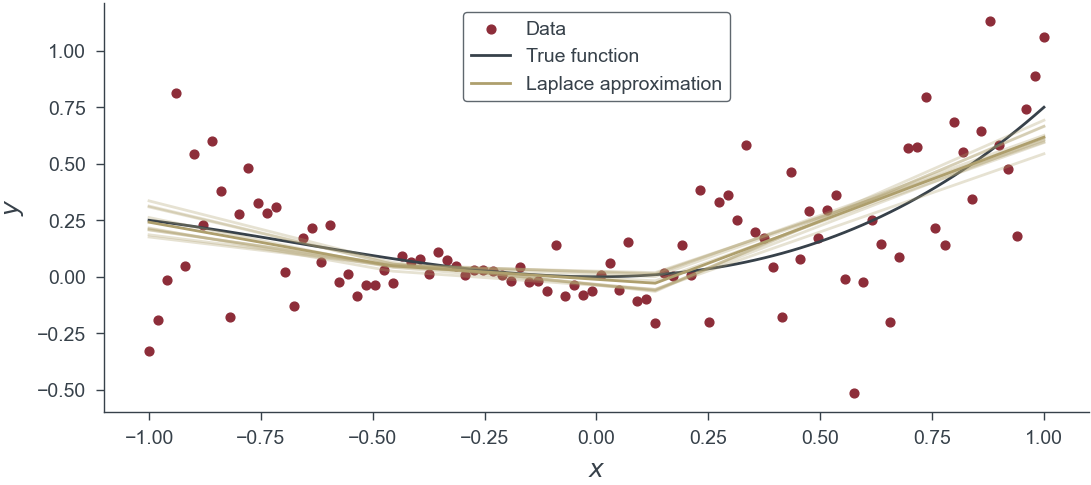

In [62]:
with torch.no_grad():
    epistemic_std = std_mc_outputs
    aleatoric_std = torch.exp(fixed_log_noise_std) + epistemic_std

    plot_results(
        mean_mc_outputs,
        epistemic_std=None,
        aleatoric_std=None,
        model_name="Laplace approximation",
    )

    for i in range(10):
        plt.plot(
            x_lin.cpu(),
            mc_outputs[i].cpu(),
            alpha=0.3,
            color="C2",
            label="Laplace approximation",
        )